#Notebook to inspect and visualize the data, perform necessary pre-processing and make the CrackDataset class ready which can be used for the MASK-RCNN model#

###Download and unzip the Crack Dataset consisting of total ~11,200 images, (from 12 different datasets)###

In [ ]:
!cp -f '/content/drive/My Drive/FireVisor/crack_segmentation_dataset.zip' /content

In [ ]:
!unzip /content/crack_segmentation_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: crack_segmentation_dataset/train/masks/Rissbilder_for_Florian_9S6A2817_34_1828_3755_3708.jpg  
  inflating: crack_segmentation_dataset/train/masks/Rissbilder_for_Florian_9S6A2838_547_1340_1856_2398.jpg  
  inflating: crack_segmentation_dataset/train/masks/Volker_DSC01695_806_127_1820_1549.jpg  
  inflating: crack_segmentation_dataset/train/masks/noncrack_noncrack_concrete_wall_12_7.jpg.jpg  
  inflating: crack_segmentation_dataset/train/masks/CRACK500_20160405_171456_1281_361.jpg  
  inflating: crack_segmentation_dataset/train/masks/Volker_DSC01706_240_1123_1495_1323.jpg  
  inflating: crack_segmentation_dataset/train/masks/Rissbilder_for_Florian_9S6A2865_413_845_3382_2544.jpg  
  inflating: crack_segmentation_dataset/train/masks/CRACK500_20160405_171219_1_361.jpg  
  inflating: crack_segmentation_dataset/train/masks/Rissbilder_for_Florian_9S6A2823_571_2290_3080_2668.jpg  
  inflating: crack_segmentation_dataset/train/mask

###Cloning Matterport's MASK-RCNN Implementation###

In [ ]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.85 MiB | 11.03 MiB/s, done.
Resolving deltas: 100% (563/563), done.


###Lets Inspect the training data###

In [ ]:
# Finding number of training images which doesn't have any crack, which can be filtered using 'noncrack*' in image filename

import os

count = 0
for image_filename in os.listdir('/content/crack_segmentation_dataset/train/images'):

  if 'noncrack' in image_filename:
    count+=1

print(f"number of training images which doesn't have any crack : {count}")



number of training images which doesn't have any crack : 1199


CFD_035.jpg
Image


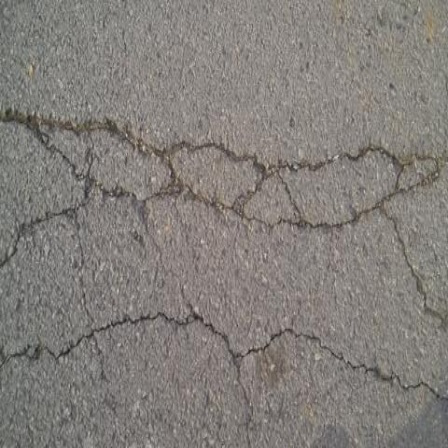

Mask


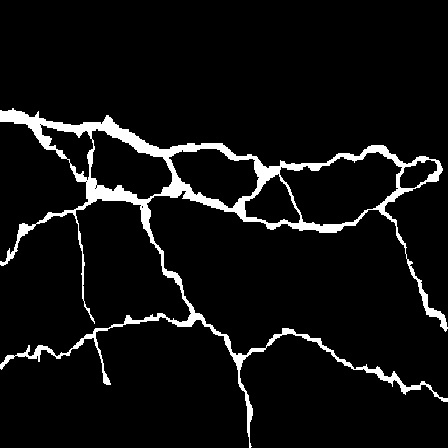

Rissbilder_for_Florian_9S6A3114_0_0_3840_5760.jpg
Image


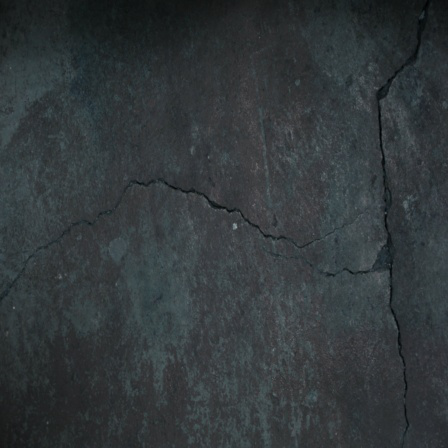

Mask


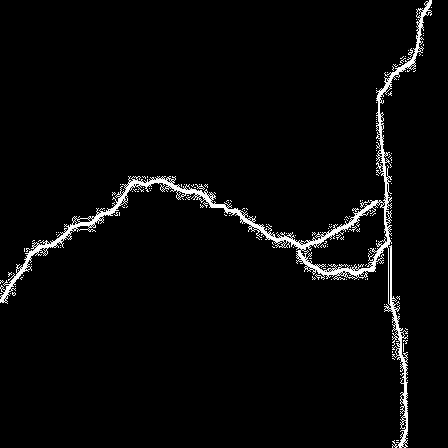

In [ ]:
# Visualize some train images and their masks

from PIL import Image
import random
import numpy as np

train_img_dir = '/content/crack_segmentation_dataset/train/images'
train_mask_dir = '/content/crack_segmentation_dataset/train/masks'

filenames = np.random.choice(os.listdir(train_img_dir), 2)

for filename in filenames:
  
  print(filename)

  print('Image')
  display(Image.open(os.path.join(train_img_dir, filename)))
  
  print('Mask')
  display(Image.open(os.path.join(train_mask_dir, filename)))



###It seeming some pre-processing is required for the masks, will do it, but let's first try to prepare the CrackDataset ready and visualize its output, and then will do all necessary pre-processing and other steps###

In [ ]:
%cd /content/Mask_RCNN

import os
import random

import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from mrcnn import utils
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 



/content/Mask_RCNN


In [ ]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

###CrackDataset class, here I assumed that in a image there can be only one bounding box and one mask (which is combined one), even if there are more than 1 diff patches of cracks in  different regions, both will be bound by with only one bounding box and be included in same mask (which is the combined mask).###

In [ ]:
def get_thresholded_masks(mask_image):

  # Thresholding the mask_image by taking valuing of just one channel, as I have have checked all channels have same values
  mask_1_ch = mask_image[:,:,0].copy()
  temp_mask_1_ch = mask_1_ch.copy()
  mask_1_ch[temp_mask_1_ch >= 127] = 1
  mask_1_ch[temp_mask_1_ch < 127] = 0

  return mask_1_ch


class CracksDataset(utils.Dataset):

  def load_dataset(self, dataset_dir):

    self.add_class("cracks_dataset", 1, "crack")

    images_dir = os.path.join(dataset_dir, 'images')
    masks_dir = os.path.join(dataset_dir, 'masks')

    for filename in os.listdir(images_dir):

      if 'noncrack' in filename:
        continue

      image_id = filename[:-4]

      image_path = os.path.join(images_dir, filename)
      mask_path = os.path.join(masks_dir, filename)


      self.add_image('cracks_dataset', image_id = image_id, path = image_path, width= 448, height= 448, annotation= mask_path)


  def load_mask(self, image_id):

    mask_path = self.image_info[image_id]['annotation']
    mask_image = cv2.imread(mask_path)

    mask_1_ch = get_thresholded_masks(mask_image)

    class_ids = []
    class_ids.append(self.class_names.index('crack'))

    mask_1_ch = np.expand_dims(mask_1_ch, axis=-1)

    return mask_1_ch, np.asarray(class_ids, dtype='int32')

  def image_reference(self, image_id):
      info = self.image_info[image_id]
      return info['path']



In [ ]:
train_dir = '/content/crack_segmentation_dataset/train'

dataset_train = CracksDataset()
dataset_train.load_dataset(train_dir)
dataset_train.prepare()


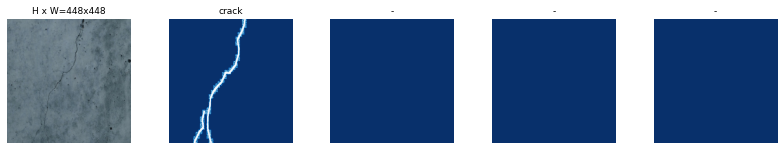

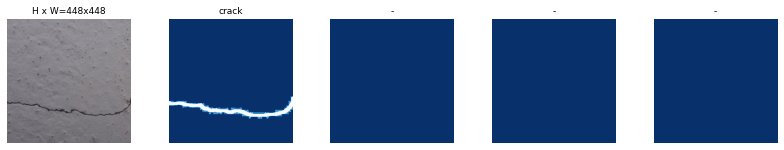

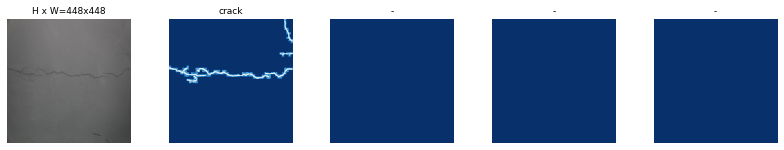

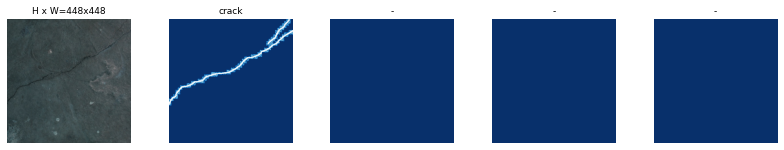

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

image_id  3678 /content/crack_segmentation_dataset/train/images/Rissbilder_for_Florian_9S6A3109_720_2929_2530_2343.jpg
image                    shape: (448, 448, 3)         min:    0.00000  max:  138.00000  uint8
mask                     shape: (448, 448, 1)         min:    0.00000  max:    1.00000  uint8
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:    0.00000  max:  448.00000  int32


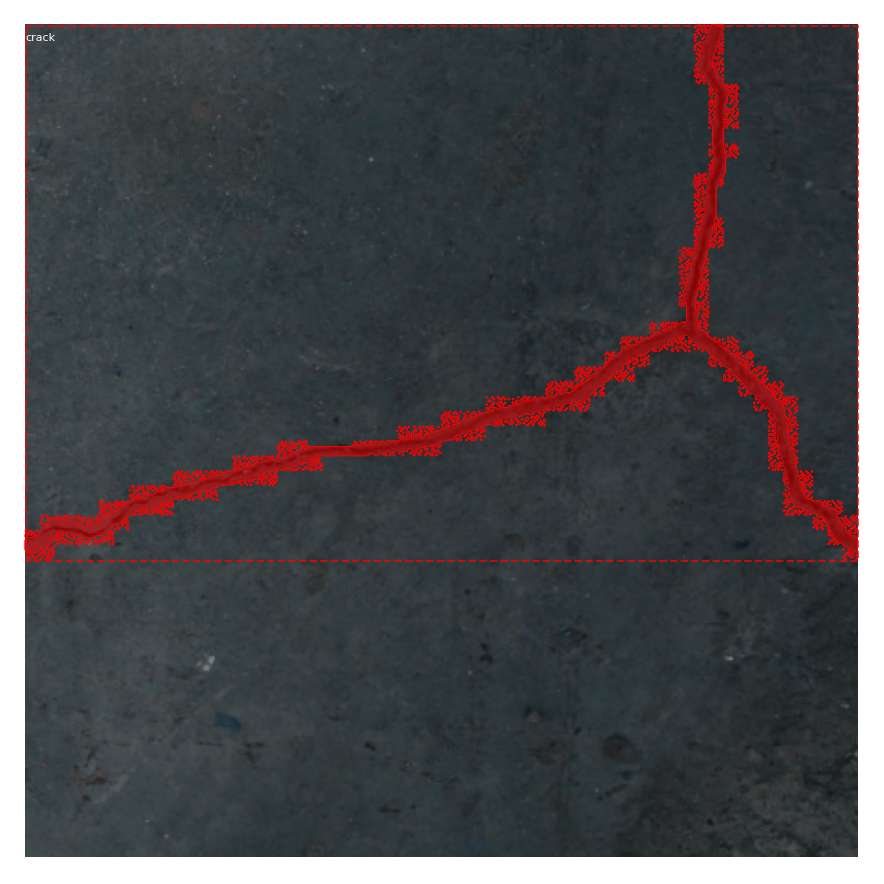

image_id  7425 /content/crack_segmentation_dataset/train/images/CRACK500_IMG_2942_1_485.jpg
image                    shape: (448, 448, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (448, 448, 1)         min:    0.00000  max:    1.00000  uint8
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:    5.00000  max:  432.00000  int32


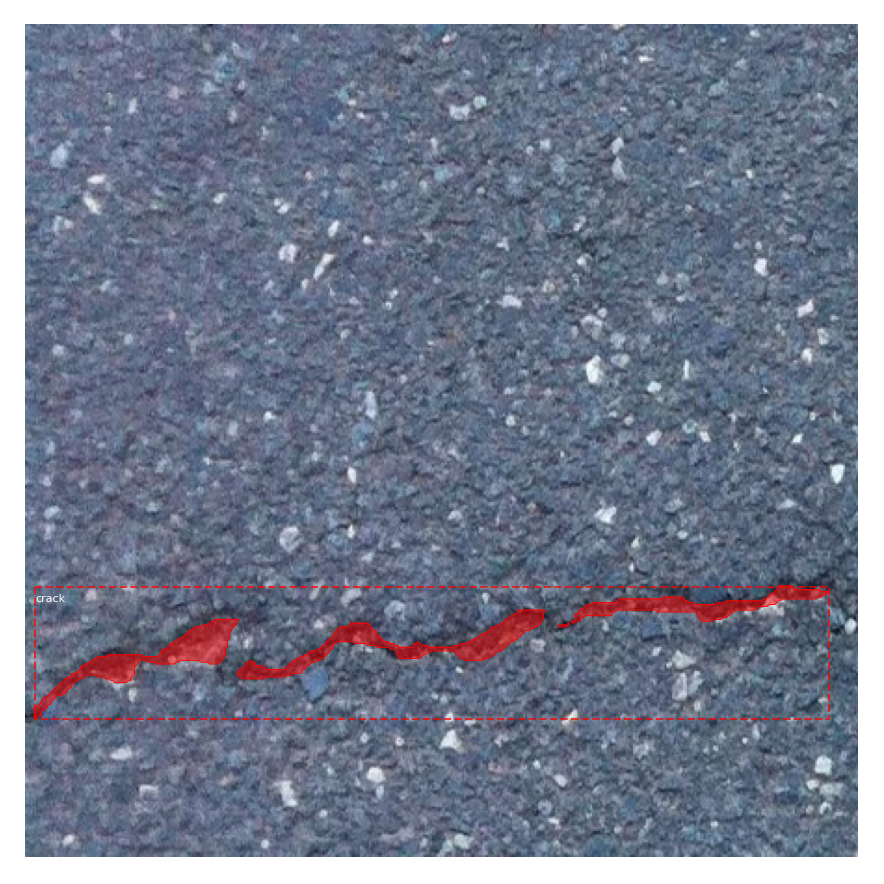

In [ ]:
# Load random image and mask.
image_ids = np.random.choice(dataset_train.image_ids, 2)
for image_id in image_ids:

  image = dataset_train.load_image(image_id)
  mask, class_ids = dataset_train.load_mask(image_id)
  # Compute Bounding box
  bbox = utils.extract_bboxes(mask)

  # Display image and additional stats
  print("image_id ", image_id, dataset_train.image_reference(image_id))
  log("image", image)
  log("mask", mask)
  log("class_ids", class_ids)
  log("bbox", bbox)
  # Display image and instances
  visualize.display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

###So now let's work on how to pre-process and remove the noise from the masks and how to get different masks/bounding boxes for different cracks in different portions of image### 

1- I did opening and closing on the thresholded mask to remove the noise from the mask.

2- I used the concepts of connected components to gets different masks/bounding boxes for different cracks in different positions of image

**I checked the validity of these steps after trying different techniques, on 4-6 different images which I think can cover the space of whole dataset (just by visualizing) :).

###So let's test these techniques for those 4-6 images### 

Image


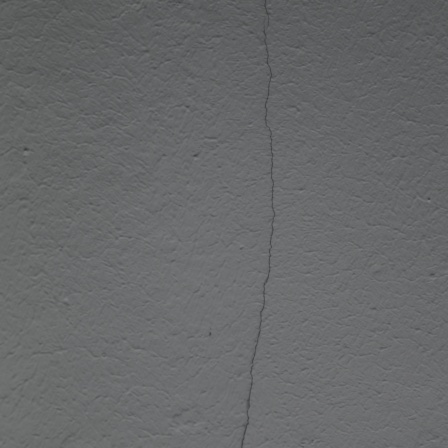

Combined Mask


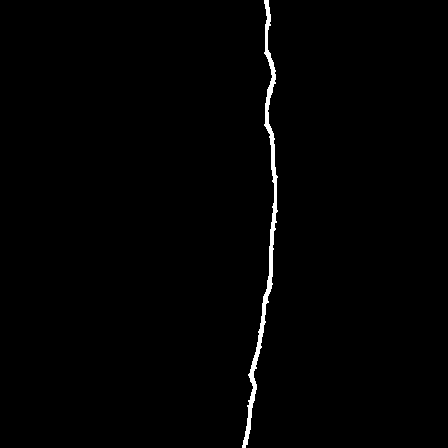

Different mask : 0


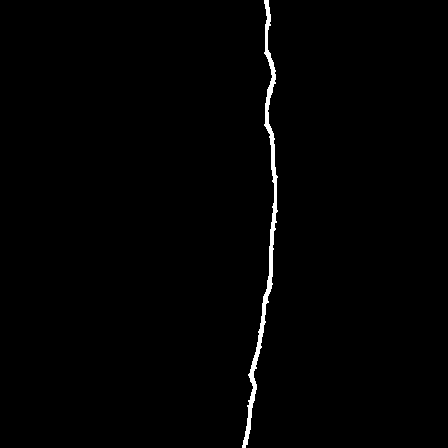

Image


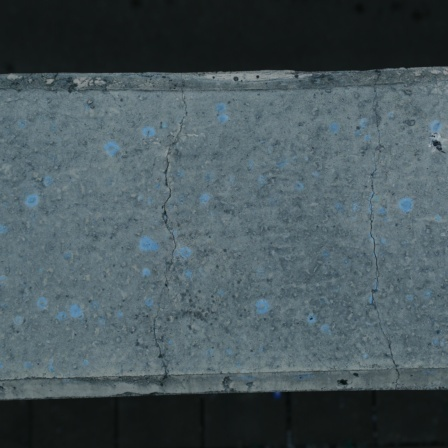

Combined Mask


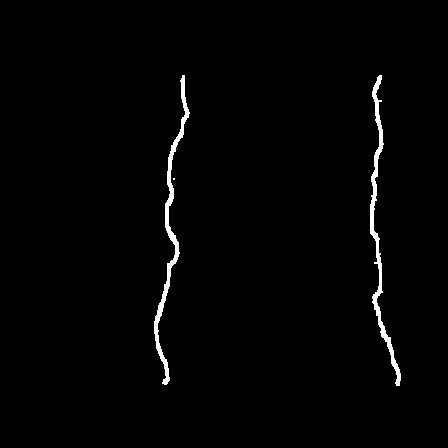

Different mask : 0


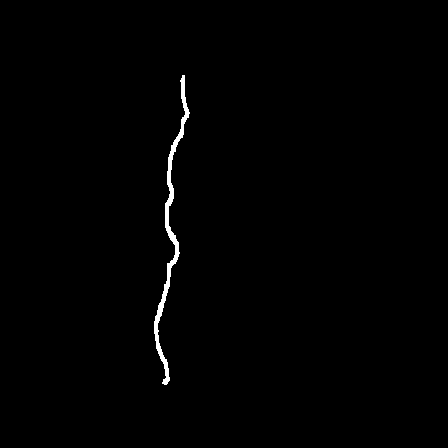

Different mask : 0


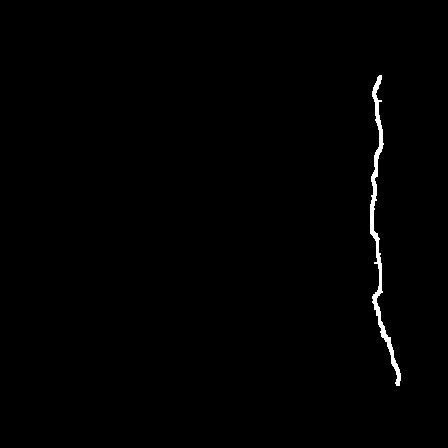

Image


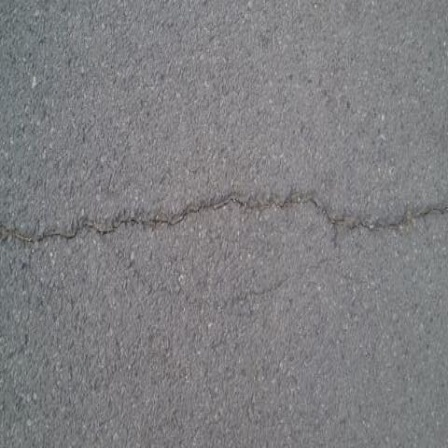

Combined Mask


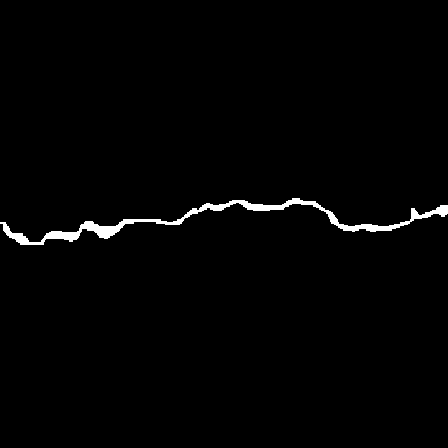

Different mask : 0


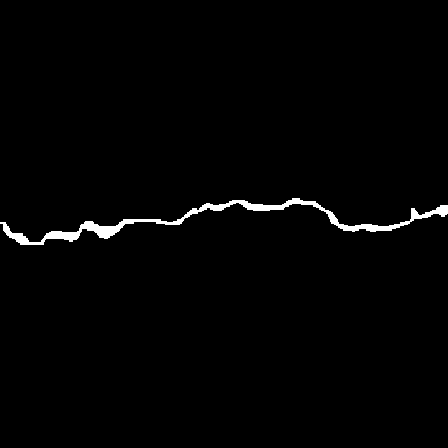

Image


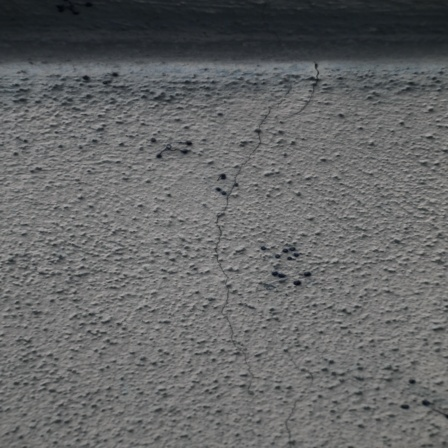

Combined Mask


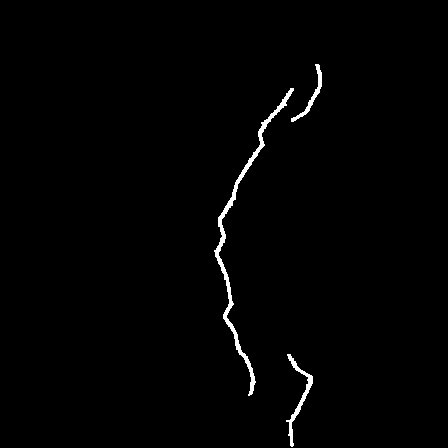

Different mask : 0


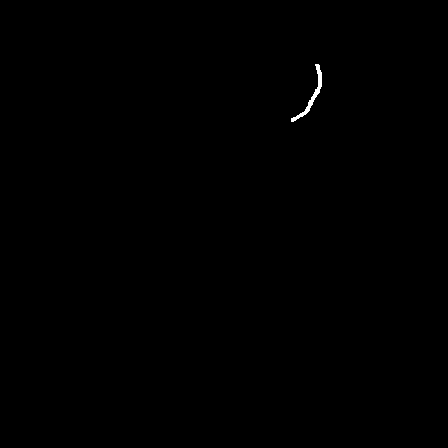

Different mask : 0


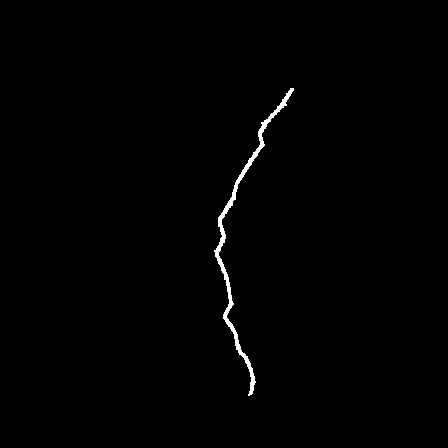

Different mask : 0


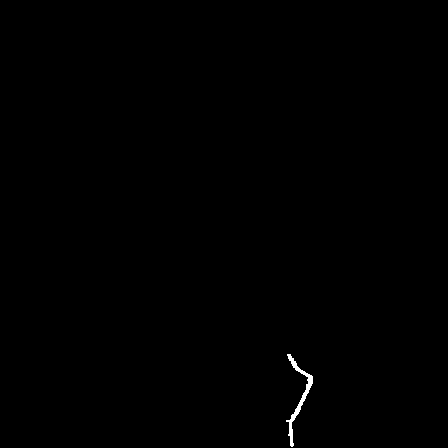

Image


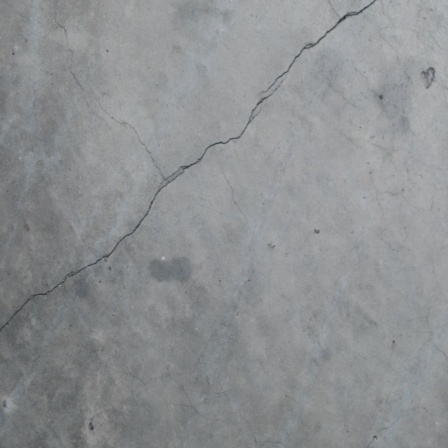

Combined Mask


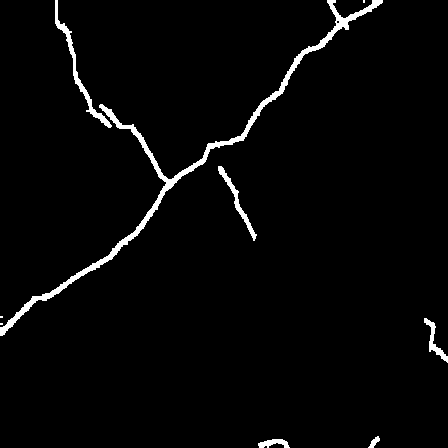

Different mask : 0


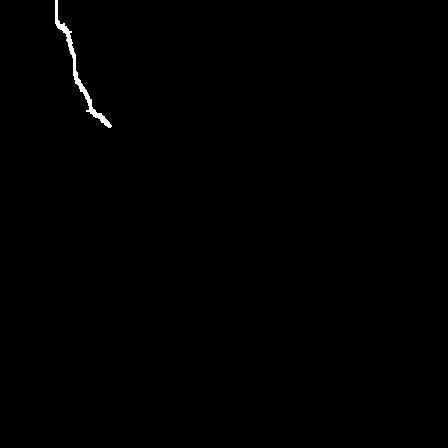

Different mask : 0


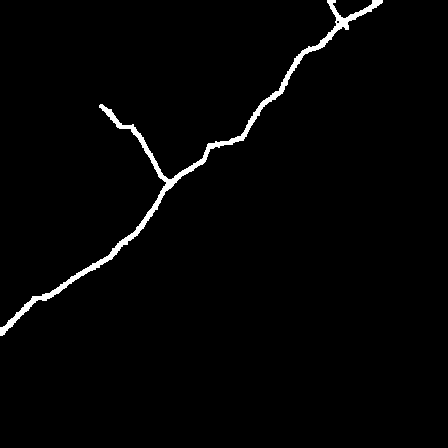

Different mask : 0


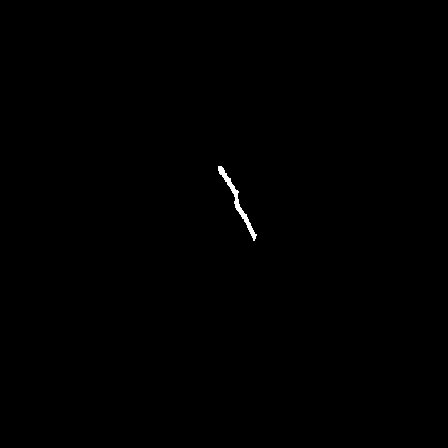

Different mask : 0


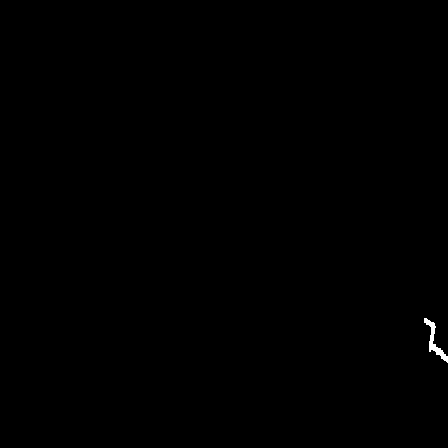

Image


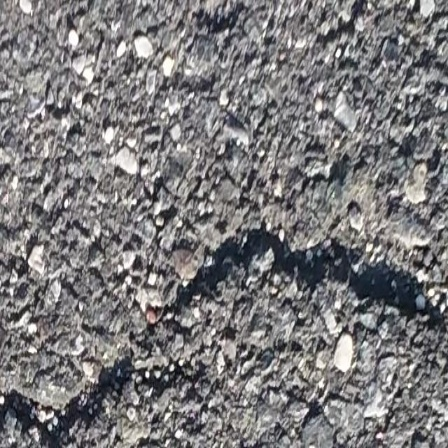

Combined Mask


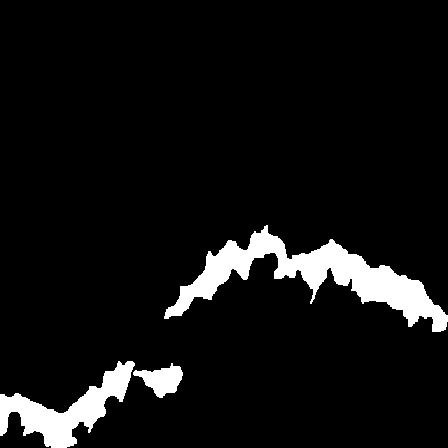

Different mask : 0


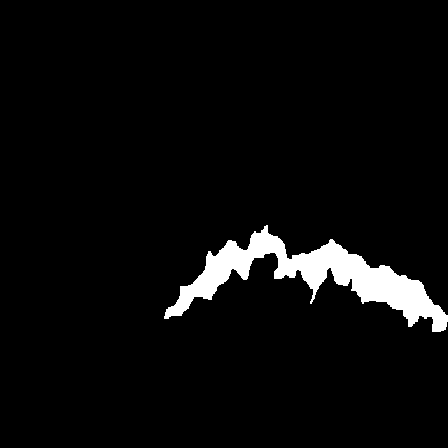

Different mask : 0


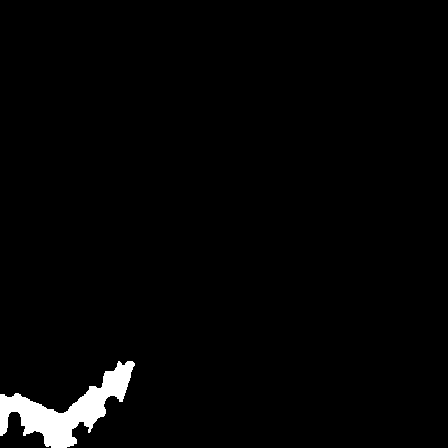

Different mask : 0


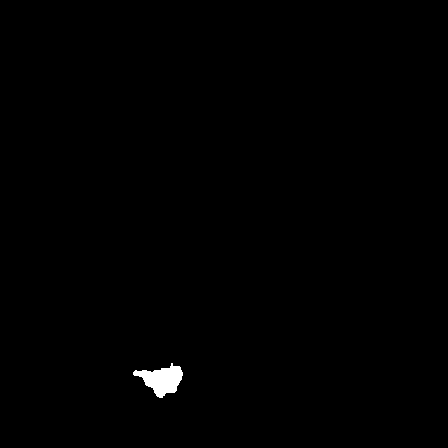

In [ ]:
# function which do both the steps 1 and 2

def remove_noise_and_get_masks(mask_1_ch):
  
  # do opening and closing
  kernel = np.ones((2,2),np.uint8)
  opening = cv2.morphologyEx(mask_1_ch, cv2.MORPH_OPEN, kernel)
  closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

  combined_mask = closing.copy()
  

  # get different masks using connected components
  max_positive_area = 0
  index_with_max_area = -1
  index = 0

  masks = []

  ret, labels = cv2.connectedComponents(combined_mask)

  for label in np.unique(labels):

    mask = np.zeros((448, 448), dtype='uint8')
    mask[labels == label] = 1

    positive_area = mask.sum()
    #print(max_positive_area)

    if positive_area>max_positive_area:
      max_positive_area = positive_area
      index_with_max_area = index

    # <200 will be ignored to not get the noisy components 
    if positive_area>=200:
      masks.append(mask)

    else:
      continue

    index += 1

  # removed the mask for backgroung which I have assumed will be the biggest (from all regions of cracks) in all images 
  masks.pop(index_with_max_area)

  return combined_mask, masks




from google.colab.patches import cv2_imshow

img_dir = '/content/crack_segmentation_dataset/train/images'
mask_dir = '/content/crack_segmentation_dataset/train/masks'
filenames = ['Rissbilder_for_Florian_9S6A2892_946_48_3664_3438.jpg', 'Rissbilder_for_Florian_9S6A2818_181_563_3454_3645.jpg', 'CFD_009.jpg', 'Rissbilder_for_Florian_9S6A2923_0_0_5760_3840.jpg', 'Rissbilder_for_Florian_9S6A3102_418_1819_3010_3845.jpg', 'CRACK500_20160324_170542_1281_361.jpg']

for filename in filenames:

  img_image = cv2.imread(os.path.join(img_dir, filename))
  print('Image')
  cv2_imshow(img_image)
  
  mask_image = cv2.imread(os.path.join(mask_dir, filename))
  mask_1_ch = get_thresholded_masks(mask_image)

  combined_mask, different_masks = remove_noise_and_get_masks(mask_1_ch)

  print('Combined Mask')
  cv2_imshow(combined_mask*255)

  count = 0
  for mask in different_masks:
    print(f'Different mask : {count}')
    cv2_imshow(mask*255)



  



###So now let's update the CrackDataset's load_mask function, to get the final updated class and then test it###

In [ ]:
class CracksDataset(utils.Dataset):

  def load_dataset(self, dataset_dir):

    self.add_class("cracks_dataset", 1, "crack")

    images_dir = os.path.join(dataset_dir, 'images')
    masks_dir = os.path.join(dataset_dir, 'masks')

    for filename in os.listdir(images_dir):

      if 'noncrack' in filename:
        continue


      mask_image = cv2.imread(os.path.join(masks_dir, filename))
      mask_1_ch = get_thresholded_masks(mask_image)
      _, different_masks = remove_noise_and_get_masks(mask_1_ch)

      if len(different_masks)==0:
        continue

      image_id = filename[:-4]

      image_path = os.path.join(images_dir, filename)
      mask_path = os.path.join(masks_dir, filename)


      self.add_image('cracks_dataset', image_id = image_id, path = image_path, width= 448, height= 448, annotation= mask_path)


  def load_mask(self, image_id):

    mask_path = self.image_info[image_id]['annotation']
    mask_image = cv2.imread(mask_path)

    mask_1_ch = get_thresholded_masks(mask_image)

    _, different_masks = remove_noise_and_get_masks(mask_1_ch)

    masks = np.array(different_masks)
    masks = np.moveaxis(masks, 0, -1)
    

    class_ids = []
    
    for i in different_masks: 
      class_ids.append(self.class_names.index('crack'))

    return masks, np.asarray(class_ids, dtype='int32')

  def image_reference(self, image_id):
      info = self.image_info[image_id]
      return info['path']



In [ ]:
train_dir = '/content/crack_segmentation_dataset/train'

dataset_train = CracksDataset()
dataset_train.load_dataset(train_dir)
dataset_train.prepare()


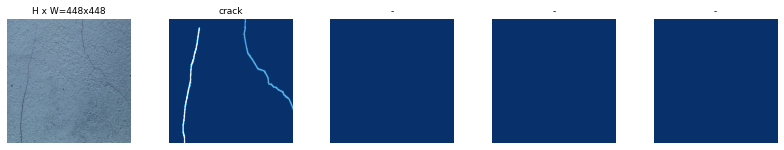

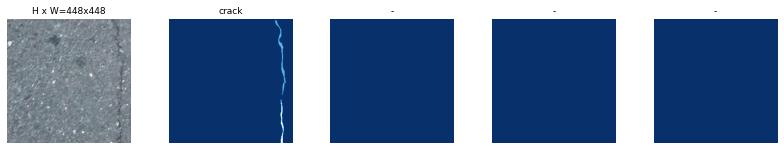

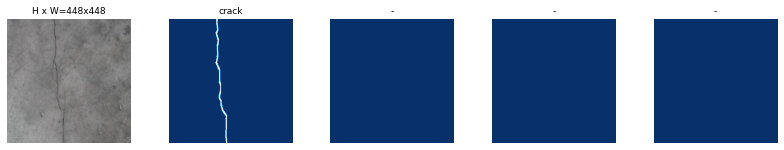

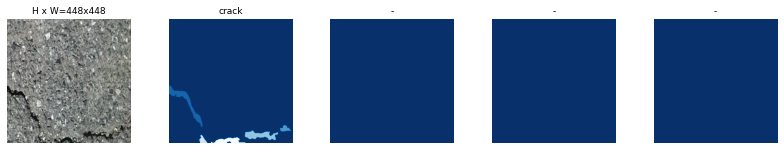

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

image_id  3018 /content/crack_segmentation_dataset/train/images/CRACK500_20160328_153553_641_721.jpg
image                    shape: (448, 448, 3)         min:    0.00000  max:  237.00000  uint8
mask                     shape: (448, 448, 1)         min:    0.00000  max:    1.00000  uint8
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:    0.00000  max:  448.00000  int32


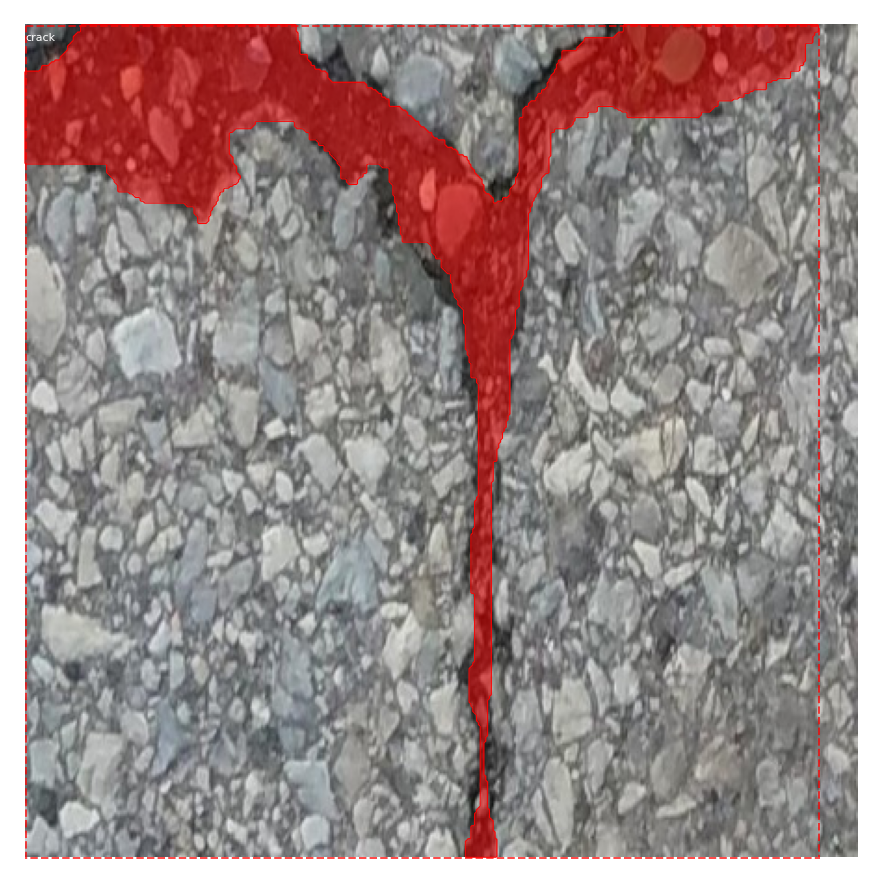

image_id  3514 /content/crack_segmentation_dataset/train/images/Rissbilder_for_Florian_9S6A2837_158_672_3496_4093.jpg
image                    shape: (448, 448, 3)         min:    0.00000  max:  238.00000  uint8
mask                     shape: (448, 448, 6)         min:    0.00000  max:    1.00000  uint8
class_ids                shape: (6,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (6, 4)                min:    0.00000  max:  448.00000  int32


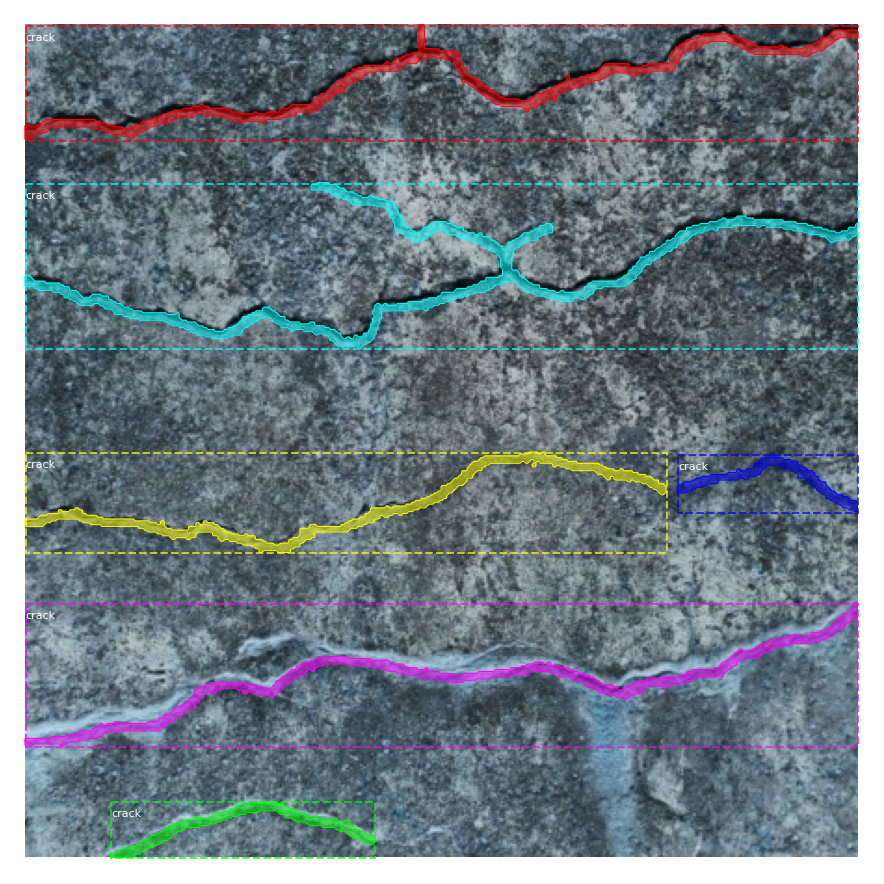

In [ ]:
# Load random image and mask.
image_ids = np.random.choice(dataset_train.image_ids, 2)
for image_id in image_ids:

  image = dataset_train.load_image(image_id)
  mask, class_ids = dataset_train.load_mask(image_id)
  # Compute Bounding box
  bbox = utils.extract_bboxes(mask)

  # Display image and additional stats
  print("image_id ", image_id, dataset_train.image_reference(image_id))
  log("image", image)
  log("mask", mask)
  log("class_ids", class_ids)
  log("bbox", bbox)
  # Display image and instances
  visualize.display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

##I have pushed CrackDataset class with remove_noise_and_get_masks and get_thresholded_masks to CrackDataset_with_its_utils.py to use further for the MASK-RCNN##